In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
import array
import matplotlib
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('text', usetex=False)

In [2]:
t = pc.tpc_calibration()

In [3]:
recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)

/home/jeef/workspace/jeff_workspace/calibration/perform_calibrations.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['full_corrected_energy'][index] = dataframe['saturation_corrected_energy'][index] #truncate full correction range
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jeef/workspace/jeff_workspace/calibration/perform_calibrations.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

# Semi-loose x-ray veto
#### Use uncorrected energies for this, as x-rays may blend into recoil bands after correcting

In [4]:
### PERFORM CUTS
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    recoils[tpc] = recoils[tpc].loc[recoils[tpc]['track_energy']>6] #initial x-ray veto
    recoils[tpc].index = [i for i in range(0,len(recoils[tpc]))] #reindex
    # TPC QUADRATIC CUTS
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    recoils[tpc] = recoils[tpc].loc[ #x-ray veto quadratic cut recoil
        recoils[tpc]['track_energy'] > cut[0]*recoils[tpc]['length']**2
        +cut[1]*recoils[tpc]['length']+cut[2]] #after this cut, only recoil bands remain

### Plot uncorrected and corrected recoil bands

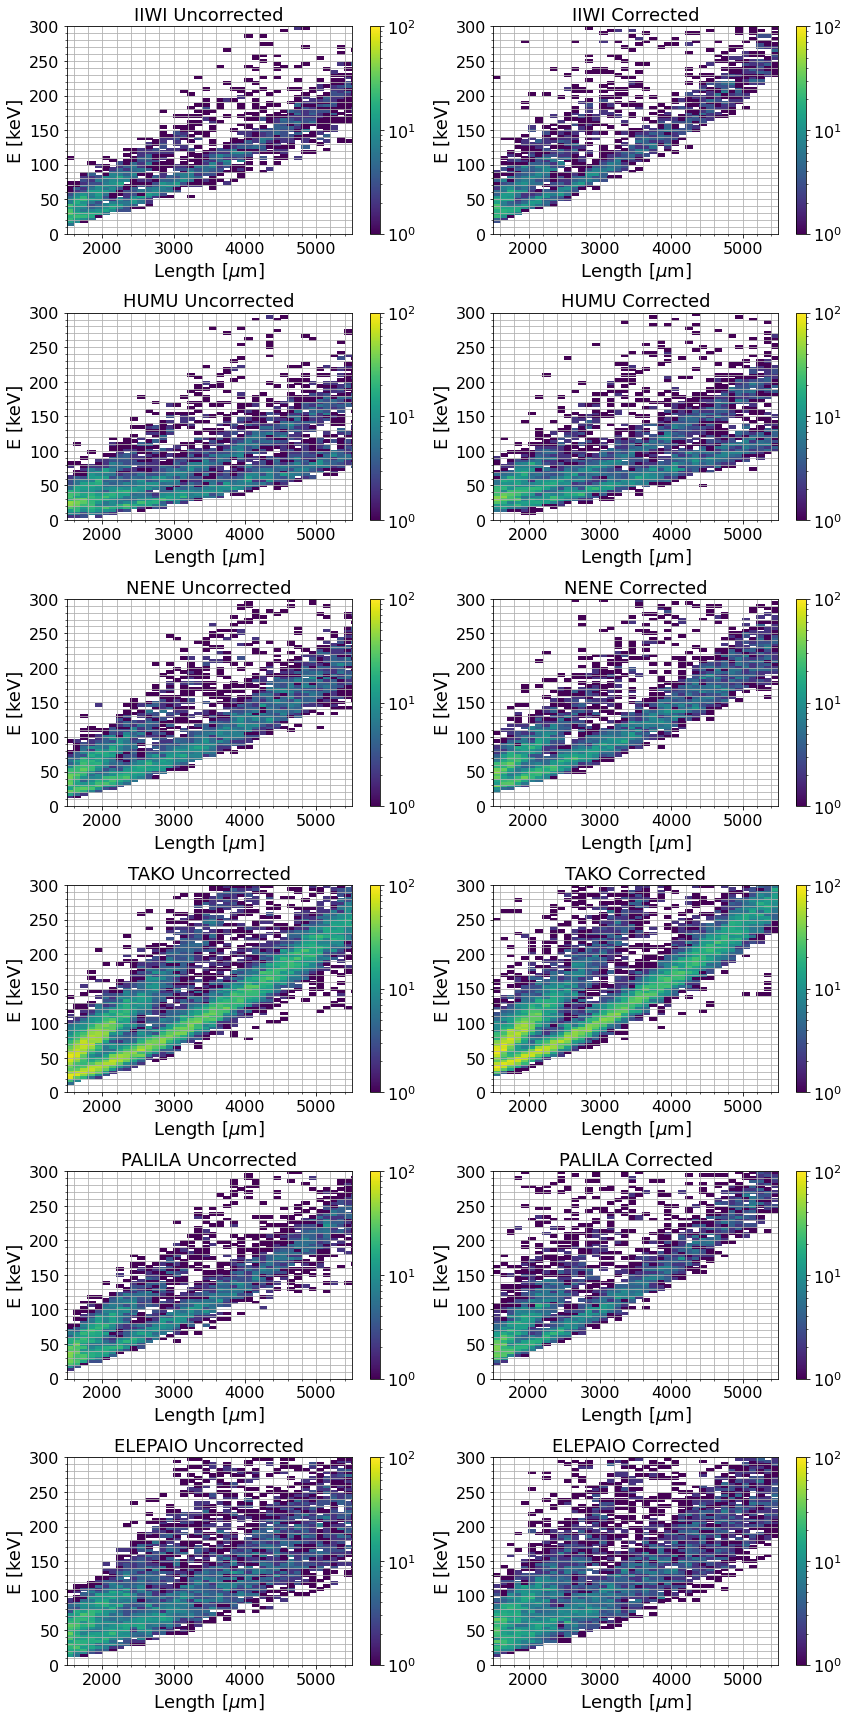

In [8]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 8000
ym = 400
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    p = plt.subplot(6,2,i)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(1500,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    p = plt.subplot(6,2,i+1)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(1500,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Plot He recoil band cuts to be used as training sample for double gaussian fitter

iiwi [ 6.66666667e-06  6.00000000e-03 -6.66666667e+00] [ 8.61111111e-06  1.37222222e-02 -3.88888889e+00]
humu [ 3.33333333e-06 -2.00000000e-03  6.66666667e+00] [ 4.86111111e-06  2.76388889e-02 -1.97222222e+01]
nene [ 5.83333333e-06 -1.66666667e-04  9.00000000e+00] [ 5.83333333e-06  2.98333333e-02 -2.10000000e+01]
tako [6.80555556e-06 3.61111111e-04 8.05555556e+00] [ 6.66666667e-06  2.93333333e-02 -1.33333333e+01]
palila [ 4.44444444e-06  2.28888889e-02 -2.55555556e+01] [ 4.16666667e-06  5.08333333e-02 -4.83333333e+01]
elepaio [ 7.50000000e-06 -7.83333333e-03  1.66666667e+00] [ 6.66666667e-06  3.93333333e-02 -5.33333333e+01]


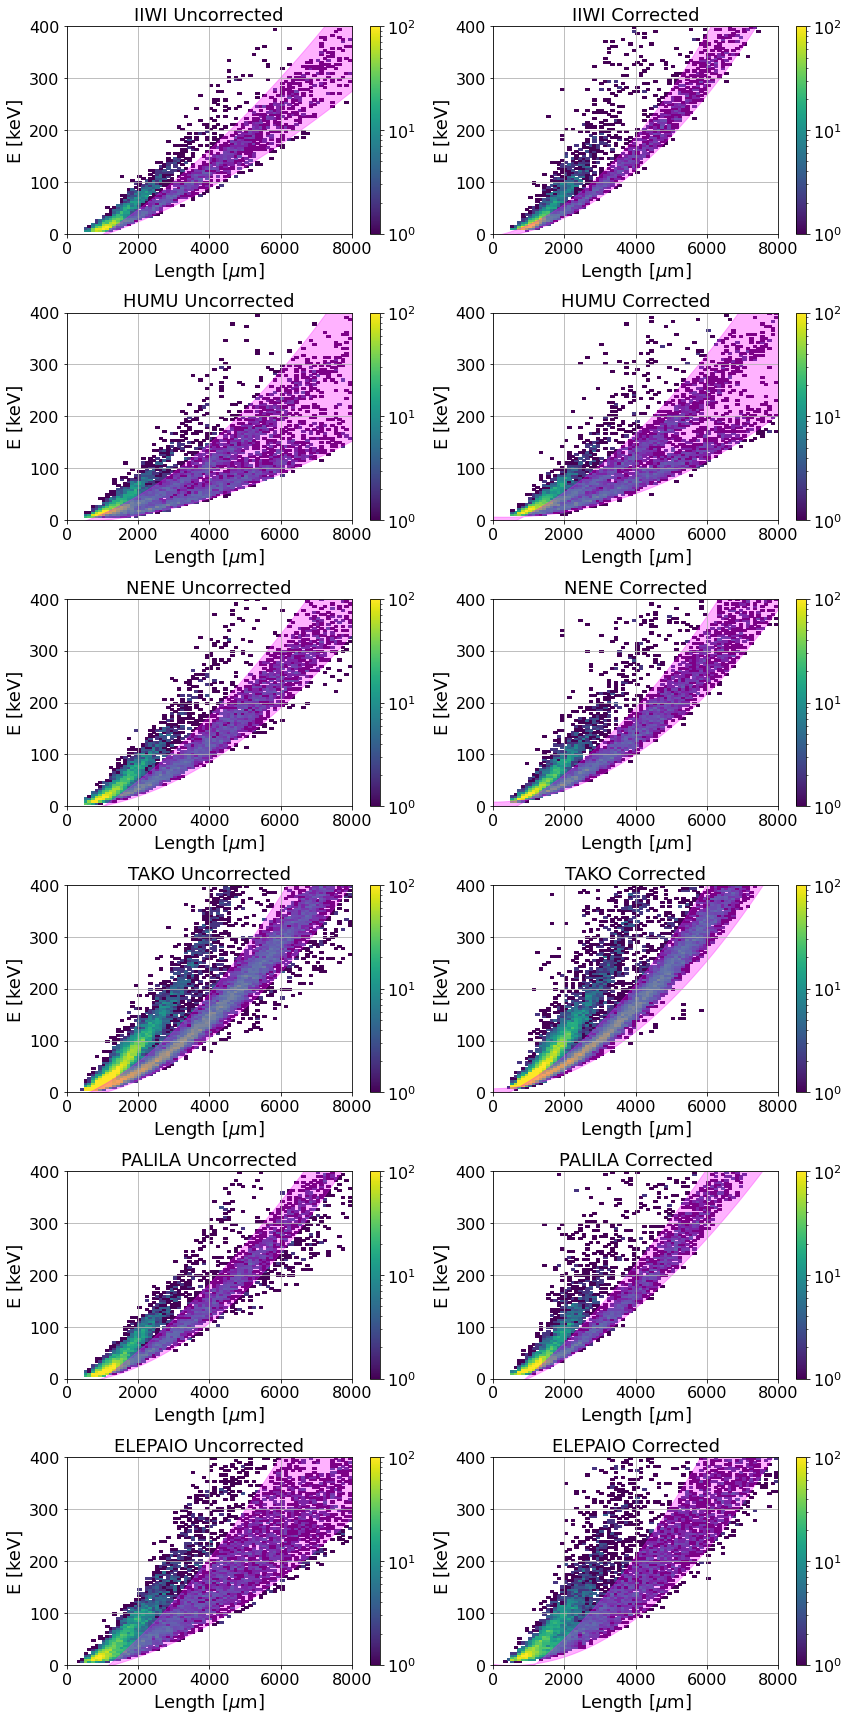

In [10]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 8000
ym = 400
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

x_plt = np.linspace(0,xm,xm+1)

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    
    #UNCORRECTED RECOILS
    plt.subplot(6,2,i)
    
    x = np.array([2000, 2600, 5000])
    if tpc == 'iiwi':
        y_min = np.array([24, 42, 130])
        y_max = np.array([48, 80, 230])
    elif tpc == 'humu':
        y_min = np.array([10, 18, 64])
        y_max = np.array([48, 74, 214])
    elif tpc == 'nene':
        y_min = np.array([20, 36, 134])
        y_max = np.array([50, 84, 250])
    elif tpc == 'tako':
        y_min = np.array([24, 44, 164])
        y_max = np.array([60, 94, 280])
    elif tpc == 'palila':
        y_min = np.array([24, 44, 170])
        y_max = np.array([54, 90, 260])
    else:
        y_min = np.array([16, 32, 120])
        y_max = np.array([52, 94, 300])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    #print(tpc, cut_min, cut_max)
    
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    
    #CORRECTED RECOILS
    plt.subplot(6,2,i+1)
    
    if tpc == 'iiwi':
        y_min = np.array([32, 54, 190])
        y_max = np.array([58, 90, 280])
    elif tpc == 'humu':
        y_min = np.array([16, 24, 80])
        y_max = np.array([55, 85, 240])
    elif tpc == 'nene':
        y_min = np.array([32, 48, 154])
        y_max = np.array([62, 96, 274])
    elif tpc == 'tako':
        y_min = np.array([36, 55, 180])
        y_max = np.array([72, 108, 300])
    elif tpc == 'palila':
        y_min = np.array([38, 64, 200])
        y_max = np.array([70, 112, 310])
    else:
        y_min = np.array([16, 32, 150])
        y_max = np.array([52, 94, 310])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    print(tpc, cut_min, cut_max)
    
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Apply cuts from He recoil bands

In [11]:
def apply_He_band_cuts(df, ecor = 'corrected'): #Cuts to train double Gaussian fit
    
    #FIRST APPLY INITIAL X-RAY VETO (already done if using .ipynb)
    
    df = df.loc[df['track_energy']>6] #initial x-ray veto
    df.index = [i for i in range(0,len(df))] #reindex
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    df = df.loc[ #x-ray veto quadratic cut recoil
        df['track_energy'] > cut[0]*df['length']**2
        +cut[1]*df['length']+cut[2]] #after this cut, only recoil bands remain
    
    #NOW MAKE SELECTIONS FOR HE RECOIL BANDS
    
    if ecor != 'corrected': #Uncorrected energies
        if tpc == 'iiwi':
            cut_min = np.array([2.22222222e-06, 1.97777778e-02, -2.44444444e+01])
            cut_max = np.array([3.05555556e-06, 3.92777778e-02, -4.27777778e+01])
        elif tpc == 'humu':
            cut_min = np.array([1.94444444e-06, 4.38888889e-03, -6.55555556e+00])
            cut_max = np.array([5.00000000e-06, 2.03333333e-02, -1.26666667e+01])
        elif tpc == 'nene':
            cut_min = np.array([4.72222222e-06, 4.94444444e-03, -8.77777778e+00])
            cut_max = np.array([4.16666667e-06, 3.75000000e-02, -4.16666667e+01])
        elif tpc == 'tako':
            cut_min = np.array([5.55555556e-06, 7.77777778e-03, -1.37777778e+01])
            cut_max = np.array([6.94444444e-06, 2.47222222e-02, -1.72222222e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.38888889e-06, 3.94444444e-03, -9.44444444e+00])
            cut_max = np.array([3.61111111e-06, 4.33888889e-02, -4.72222222e+01])
        else:
            cut_min = np.array([3.33333333e-06, 1.13333333e-02, -2.00000000e+01])
            cut_max = np.array([5.27777778e-06, 4.57222222e-02, -6.05555556e+01])
        ekey = 'track_energy' #Use this key for raw, uncorrected energy
        
    else:
        if tpc == 'iiwi':
            cut_min = np.array([6.66666667e-06, 6.00000000e-03, -6.66666667e+00])
            cut_max = np.array([8.61111111e-06, 1.37222222e-02, -3.88888889e+00])
        elif tpc == 'humu':
            cut_min = np.array([3.33333333e-06, -2.00000000e-03,  6.66666667e+00])
            cut_max = np.array([4.86111111e-06, 2.76388889e-02, -1.97222222e+01])
        elif tpc == 'nene':
            cut_min = np.array([5.83333333e-06, -1.66666667e-04,  9.00000000e+00])
            cut_max = np.array([5.83333333e-06, 2.98333333e-02, -2.10000000e+01])
        elif tpc == 'tako':
            cut_min = np.array([6.80555556e-06, 3.61111111e-04, 8.05555556e+00])
            cut_max = np.array([6.66666667e-06, 2.93333333e-02, -1.33333333e+01])
        elif tpc == 'palila':
            cut_min = np.array([4.44444444e-06, 2.28888889e-02, -2.55555556e+01])
            cut_max = np.array([4.16666667e-06, 5.08333333e-02, -4.83333333e+01])
        else:
            cut_min = np.array([7.50000000e-06, -7.83333333e-03,  1.66666667e+00])
            cut_max = np.array([6.66666667e-06, 3.93333333e-02, -5.33333333e+01])
        ekey = 'full_corrected_energy' #key for corrected energy

    df_red = df.loc[(df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2]))
                        & (df[ekey]<(cut_max[0]*df['length']**2  +cut_max[1]*df['length']+cut_max[2]))]
    df = df.loc[df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2])]
    return df, df_red

uncorrected_recoils = {}
corrected_recoils = {}
uncorrected_red = {}
corrected_red = {}
tpcs = recoils.keys()
for tpc in tpcs:
    uncorrected_recoils[tpc], uncorrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'uncorrected')
    corrected_recoils[tpc], corrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'corrected')

### Same money plot code as before

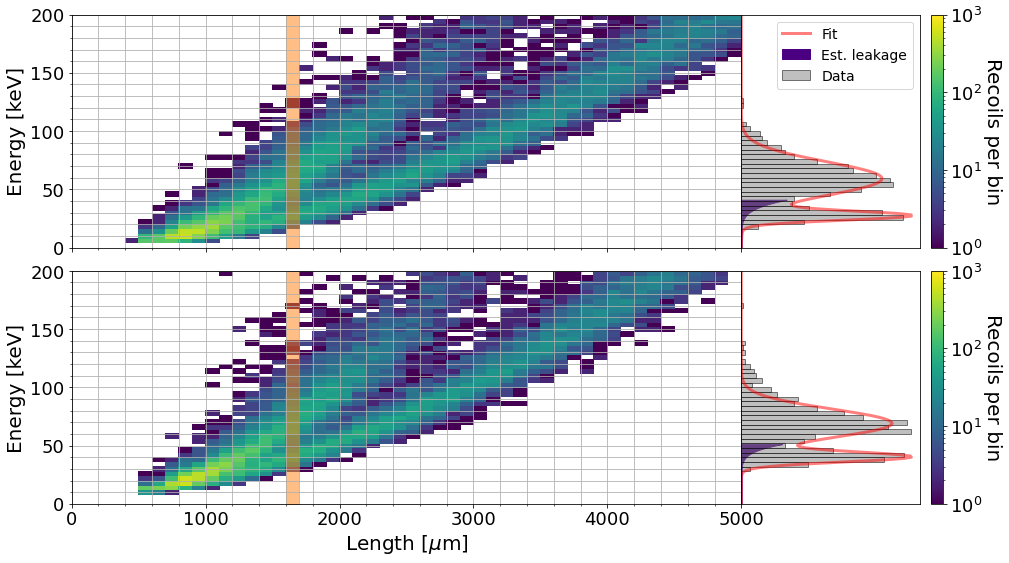

In [12]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])
sig_factor = 2 #Amount of sigmas away from Helium peak to define cutoff of leakage region

for tpc in ['tako']:
    for loc in range(16,17):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', labelsize=20)
        plt.rc('axes', titlesize=20)
        fig, ax = plt.subplots(2,2, figsize = (16,9), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,200)
        ax[0,0].set_xlim(0,5000)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='Fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', label = 'Data',edgecolor = 'black')
        ax[0,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo', label = 'Est. leakage')
        ax[0,1].set_ylim(0,200)
        #ax[0,1].set_xlim(0,220)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].legend()

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,1000,2000,3000,4000, 5000, 6000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,200)
        ax[1,0].set_xlim(0,5000)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[1,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo')
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', edgecolor = 'black')
        ax[1,1].set_ylim(0,200)
        #ax[1,1].set_xlim(0,220)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
#plt.savefig('money2.png')
plt.show()

### Generate a bunch of plots for validation

15 46 136
15 75 107
16 58 98
16 67 89
17 50 105
17 52 103
18 49 70
18 50 69
19 40 83
19 37 86
20 43 66
20 42 67
21 47 66
21 46 67
22 38 72
22 38 72
23 28 37
23 27 38
24 47 39
24 44 42
25 38 32
25 33 36
26 42 35
26 39 39
27 39 15
27 33 21
28 46 22
28 40 28
29 43 10
29 40 12
30 42 16
30 36 22
31 36 13
31 33 16
32 39 14
32 36 18
33 27 11
33 23 15
34 30 12
34 23 18


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


35 43 7
35 38 13


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


36 35 5
36 33 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


37 33 5
37 32 8


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


38 31 2
38 27 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


39 39 7
39 39 9


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


40 30 6
40 24 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


41 17 10
41 17 10


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


42 40 7
42 32 16


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


43 23 3
43 20 8


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


44 34 5
44 30 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


45 37 5
45 33 10


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


46 32 1
46 27 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


47 39 5
47 38 8


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


48 38 3
48 30 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


49 30 1
49 27 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


50 30 1
50 24 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


51 29 2
51 27 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


52 39 1
52 35 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


53 24 3
53 23 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


54 28 0
54 24 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


55 19 2
55 14 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


56 23 3
56 19 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


57 26 0
57 22 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


58 22 1
58 23 1


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


59 22 1
59 17 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


15 61 233
15 73 218


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


16 75 191
16 92 174


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


17 85 205
17 89 200


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


18 84 157
18 86 155


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


19 99 137
19 104 131


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


20 92 107
20 99 100


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


21 107 123
21 109 121


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


22 91 75
22 90 76


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


23 100 76
23 100 75


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


24 92 60
24 96 56


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


25 88 35
25 89 33


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


26 94 39
26 94 39


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


27 75 40
27 72 42


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


28 88 30
28 87 31


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


29 87 31
29 86 32


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


30 77 16
30 74 19


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


31 81 20
31 80 20


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


32 68 24
32 68 24


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


33 85 9
33 83 10


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


34 86 21
34 81 24


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


35 67 12
35 66 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


36 63 14
36 60 13


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


37 73 11
37 69 13


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


38 81 7
38 77 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


39 94 13
39 89 17


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


40 78 8
40 71 12


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


41 73 13
41 68 15


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


42 70 5
42 64 9


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


43 88 6
43 82 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


44 84 9
44 79 10


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


45 82 6
45 75 11


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


46 83 7
46 74 13


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


47 78 4
47 74 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


48 72 1
48 66 5


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


49 75 4
49 70 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


50 68 5
50 66 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


51 59 7
51 49 14


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


52 71 3
52 68 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


53 64 3
53 59 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


54 57 3
54 48 7


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


55 54 1
55 47 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


56 43 2
56 38 4


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


57 59 1
57 55 4


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


58 51 2
58 45 9


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


59 46 1
59 40 6


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


15 288 558
15 282 562


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


16 254 559
16 252 561


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


17 255 533
17 255 532


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fcdeff20b90>
Traceback (most recent call last):
  File "/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/matplotlib/transforms.py", line 177, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt: 
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


18 266 503
18 265 501


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


19 246 460
19 250 453


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


20 235 386
20 236 386


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


21 281 290
21 285 286


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


22 266 221
22 269 216


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


23 248 231
23 249 227


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


24 220 135
24 219 134


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


25 276 128
25 276 124


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


26 242 151
26 239 150


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


27 217 117
27 212 120


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


28 245 84
28 239 85


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


29 222 91
29 223 89


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


30 229 78
30 225 81


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


31 246 78
31 244 74


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


32 250 72
32 240 75


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


33 233 58
33 224 64


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


34 208 57
34 201 61


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


35 255 71
35 247 74


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


36 240 50
36 227 59


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


37 206 49
37 199 51


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


38 225 50
38 221 51


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


39 219 45
39 207 49


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


40 236 50
40 224 53


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


41 217 50
41 204 52


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


42 224 35
42 197 50


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


43 233 38
43 214 48


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


44 213 31
44 199 40


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


45 224 36
45 206 48


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


46 210 15
46 193 24


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


47 225 27
47 198 43


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


48 237 20
48 215 37


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


49 233 25
49 204 43


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


50 198 17
50 175 28


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


51 163 22
51 144 35


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


52 177 15
52 162 27


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


53 193 8
53 170 20


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


54 172 9
54 153 24


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


55 163 12
55 139 27


KeyboardInterrupt: 

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

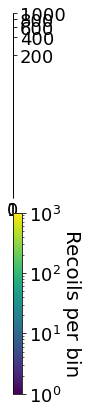

In [13]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])

for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    for loc in range(15,60):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        fig, ax = plt.subplots(2,2, figsize = (8,7), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,ym)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy)
        if 5*par6 < par3:
            if par3>20:
                seed_params = [uncorrected_recoils[tpc][ekey].mean(),uncorrected_recoils[tpc][ekey].std(),len(uncorrected_recoils[tpc][ekey])]
                try:
                    params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        else:
            if par3>20:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        ax[0,1].set_ylim(0,ym)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,2000,4000,6000,8000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,ym)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        if par3 > 20:
            if 5*par6 < par3:
                if par3 > 20:
                    seed_params = [corrected_recoils[tpc][ekey].mean(),corrected_recoils[tpc][ekey].std(),len(corrected_recoils[tpc][ekey])]
                    try:
                        params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][loc], seed_params)
                        ax[1,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                    except RuntimeError:
                        pass
                else:
                    pass
            else:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
                    ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
        else:
            pass
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy)
        ax[1,1].set_ylim(0,ym)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('%s_hist_%s.png'%(tpc, loc))
        plt.clf()

In [ ]:
import scipy.integrate as integrate
def get_resolution_and_leakage(xmax = 10000, ymax = 800, nbinsx = 100, nbinsy = 200, tpcs = ['iiwi', 'nene', 'tako', 'palila']):
    h = {}
    image = {}
    reso_dfs = {}
    sig_factor = 2
    for tpc in tpcs:
        resolution = {}
        h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.clf()
        bins = 0.5*(yedges[1:]+yedges[:-1])
        resolution['length'] = []
        resolution['energy_uncor'] = []
        resolution['energy_uncor_err'] = []
        resolution['energy_cor'] = []
        resolution['energy_cor_err'] = []
        resolution['reso_uncor'] = []
        resolution['reso_uncor_err'] = []
        resolution['reso_cor'] = []
        resolution['reso_cor_err'] = []
        resolution['leakage_uncor'] = [] #leakage from C/O band into He band
        resolution['leakage_cor'] = []
        resolution['leakage_uncor_err'] = []
        resolution['leakage_cor_err'] = []
        dx = xedges[1]-xedges[0]
        imin = int(1400/dx)
        imax = nbinsx
        for i in range(imin,imax):
            resolution['length'].append((xedges[i+1]+xedges[i])/2)
            for ekey in ['track_energy', 'full_corrected_energy']:
                if ekey == 'track_energy':
                    df = uncorrected_recoils[tpc]
                    df_red = uncorrected_red[tpc]
                else:
                    df = corrected_recoils[tpc]
                    df_red = corrected_red[tpc]
                index_He = df_red.loc[(df_red['length'] < (xedges[i+1])) & (df_red['length'] > (xedges[i]))].index.to_numpy()
                index_CO = df.loc[(df.index.isin(index_He) == False) & (df['length'] < (xedges[i+1])) & (df['length'] > (xedges[i]))].index.to_numpy()
                par1 = df_red[ekey][index_He].mean()
                par2 = df_red[ekey][index_He].std()
                par3 = len(df_red[ekey][index_He])
                par4 = df[ekey][index_CO].mean()
                par5 = df[ekey][index_CO].std()
                par6 = len(df[ekey][index_CO])
                seed_params = [par1,par2,par3,par4,par5,par6]
                def gauss(x,mu,sigma,A): # for gaussian fit
                    return A*exp(-(x-mu)**2/2/sigma**2)
                def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
                    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
                if 5*par6 < par3:
                    if par3>30:
                        seed_params = [df[ekey].mean(),df[ekey].std(),len(df[ekey])]
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
                else:
                    if par3>30:
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                resolution['leakage_uncor'].append(leakage)
                                resolution['leakage_uncor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                            else:
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                try:
                                    leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                    leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                except ZeroDivisionError:
                                    leakage = np.nan
                                    leakage_err = np.nan
                                resolution['leakage_cor'].append(leakage)
                                resolution['leakage_cor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
        reso_dfs[tpc] = pd.DataFrame.from_dict(resolution)
    return reso_dfs


### Leakage plot for tako

In [ ]:
dfs = get_resolution_and_leakage()
for tpc in dfs.keys():
    dfs[tpc] = dfs[tpc].loc[(np.abs(dfs[tpc]['reso_uncor_err'])<2*np.abs(dfs[tpc]['reso_uncor'])) & (np.abs(dfs[tpc]['reso_cor_err'])<2*np.abs(dfs[tpc]['reso_cor']))]# & (np.abs(dfs[tpc]['leakage_cor'])<.4) & (np.abs(dfs[tpc]['leakage_uncor'])<.40)]

In [ ]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
for tpc in ['iiwi']:
    fig, ax = plt.subplots(figsize = (10,8))
    #index = dfs[tpc].loc[dfs[tpc]['length']<10000].index.to_numpy()
    index = dfs[tpc].index.to_numpy()
    #ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'red', label = 'Uncorrected')
    #p1 = ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'indigo', label = 'Resolution', markeredgecolor = 'black')
    p1 = ax.errorbar(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),dfs[tpc]['energy_cor_err'], 'o', color = 'indigo', label = 'Resolution', markeredgecolor = 'black')
    ax.set_ylabel(r'$\sigma_E/E$')
    #ax.set_xlabel(r'length [$\mu$m]')
    #ax.set_xlim(0,7000)
    ax.set_xlabel(r'$E_{recoil}$ [keV]')
    ax.set_xlim(0,400)
    ax.set_ylim(0,0.2)
    ax.grid()
    ax2 = ax.twinx()
    #plt.plot(dfs[tpc]['length'],np.abs(dfs[tpc]['leakage_uncor'])*100, 'o', color = 'red', label = 'Uncorrected')
    #p2 = ax2.plot(dfs[tpc]['length'][index],np.abs(dfs[tpc]['leakage_cor'][index])*100, 's', color = 'blue', label = 'Leakage', markeredgecolor = 'black')
    p2 = ax2.plot(dfs[tpc]['energy_cor'][index], np.abs(dfs[tpc]['leakage_cor'][index])*100, 's', color = 'yellow', label = 'Leakage', markeredgecolor = 'black')
    ax2.set_ylabel(r'Leakage percentage [$\%$]')
    #plt.title(tpc)
    ax2.set_ylim(0,20)
    ax2.grid()
    markers = [p1, p2[0]]
    plt.legend(markers, [m.get_label() for m in markers])
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()